In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import r2_score

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Loading and Getting a Glimpse of the Dataset

In [42]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data/Google_Stock_Price.csv',thousands=',')
print(data.head(10))
data.shape

        Date    Open    High     Low   Close    Volume
0   1/3/2012  325.25  332.83  324.97  663.59   7380500
1   1/4/2012  331.27  333.87  329.08  666.45   5749400
2   1/5/2012  329.83  330.75  326.89  657.21   6590300
3   1/6/2012  328.34  328.77  323.68  648.24   5405900
4   1/9/2012  322.04  322.29  309.46  620.76  11688800
5  1/10/2012  313.70  315.72  307.30  621.43   8824000
6  1/11/2012  310.59  313.52  309.40  624.25   4817800
7  1/12/2012  314.43  315.26  312.08  627.92   3764400
8  1/13/2012  311.96  312.30  309.37  623.28   4631800
9  1/17/2012  314.81  314.81  311.67  626.86   3832800


(1258, 6)

In the dataset, the Volume column had thousand seperated values, which is taken as string when usually loading to Pandas DataFrame.
I have specified that ',' is used as the thousand separator when loading, so that the ',' will not be there when loading to our program. Then it'll be loaded as a numerical value.


**Plotting the Data**

Text(0, 0.5, 'Stock Volume')

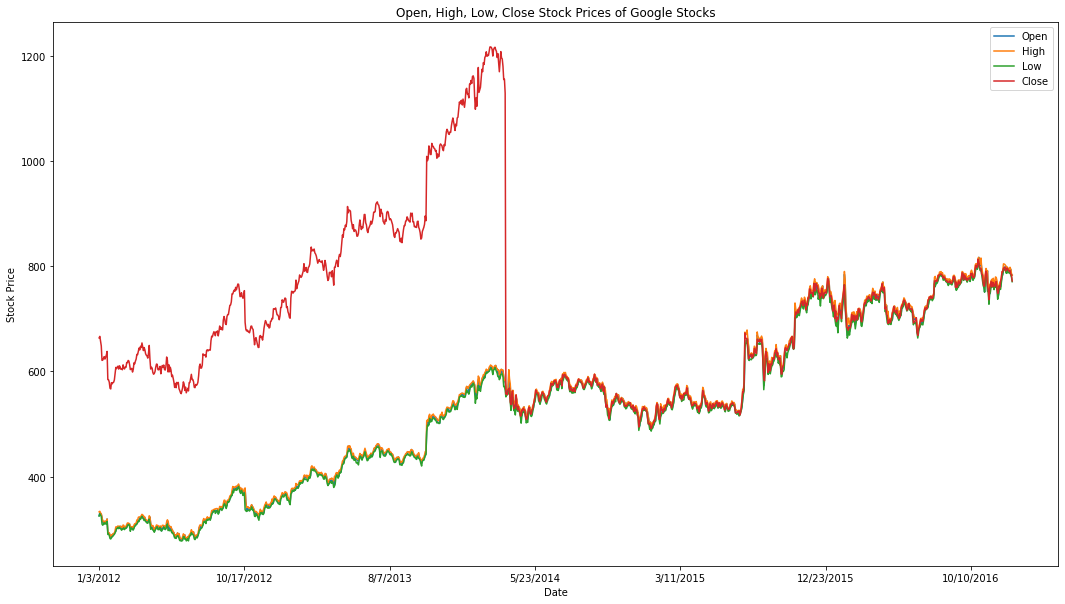

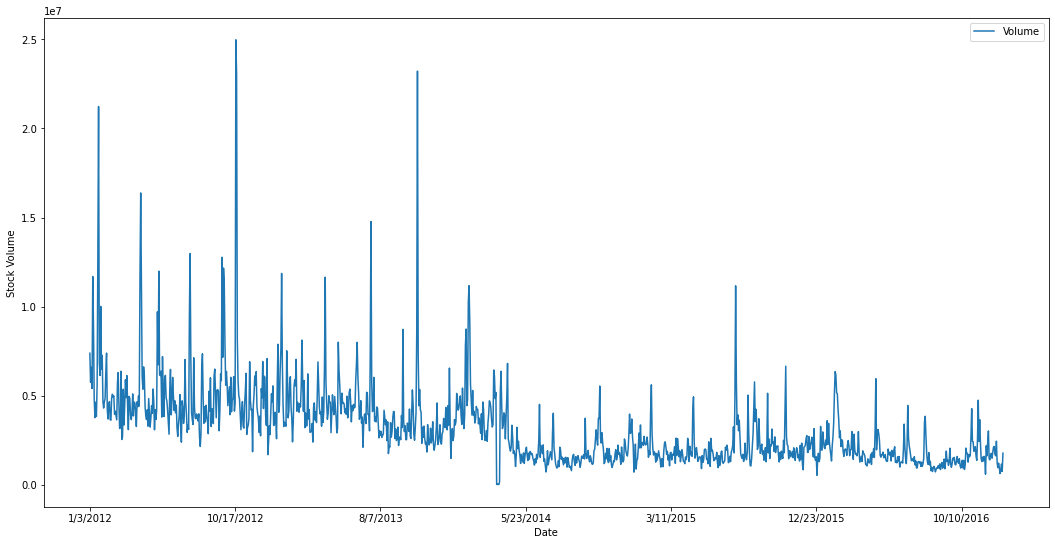

In [43]:
ax1 = data.plot(x="Date", y=["Open", "High", "Low", "Close"],  figsize=(18,10),title='Open, High, Low, Close Stock Prices of Google Stocks')
ax1.set_ylabel("Stock Price")

ax2 = data.plot(x="Date", y=["Volume"],  figsize=(18,9))
ax2.set_ylabel("Stock Volume")


When inspecting the first plot, we can see that in the closing value of stock prior to 2014/03/26, there is a significant gap between the closing price and the other prices, where as after this date, the closing price has also been closer to other prices.

When inspecting the second plot, we can see that there are significant fluctuations in the Stock Volume over the time. And it is quite hard to find a trend/pattern in this the data in Stock Volume (the one we need to predict).

# Preprocessing Data
Preprocessing data includes handling missing values and outliers, applying feature coding techniques if needed, scale & standardize features.


**Checking for Missing values**

In [5]:
# Getting a summary of missing values for each field/attribute
print(data.isnull().sum())

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


We can see that there are no missing values in the dataset.

**Handling Outliers**

According to the above graph plots that indicate the Open, High, Low and Close values of the Stock prices, the Close price is as mentioned earlier, has a significant gap with the other values. 
The surprising fact is that, the Close value has even become higher than the High value (highest price of stock for a given day), which is not real. 

Ref: https://www.mit.edu/~mbarker/formula1/f1help/11-ch-10.htm

Let us also check outliers for attributes by using box plots as follows.

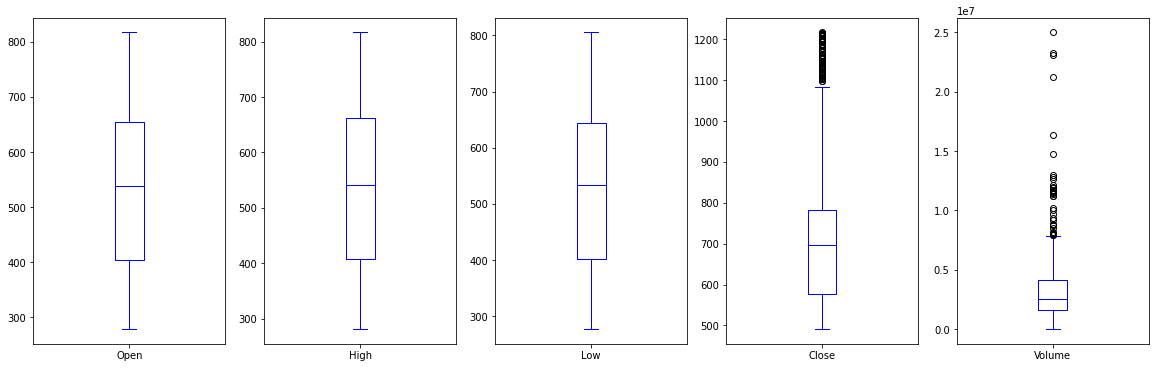

In [44]:
data[['Open','High','Low','Close','Volume']].plot(kind= 'box' ,layout=(1,5),subplots=True, sharex=False, sharey=False, figsize=(20,6),color='blue')
plt.show()

We can see that there are outliers in the Close and Volume attributes. However, i will not remove any outliers here since there are only a limited number of datapoints (less than 1300) and if we remove outliers, the dataset will become even smaller.

**Feature Encoding**

When we check the 1st 10 records of the dataset, we could see that all the data in the dataset are numerical data, and there are no categorical data that needs encoding. Therefore, no feature encoding process was carried out on this dataset.

**Feature Scaling**

MinMaxScaler, which is said to be better to be used with time-series data, was used on this dataset for the feature scaling purposes.

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

The following set of graphs show the attribute histogram before scaling

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfce0f0d10>,
      dtype=object)

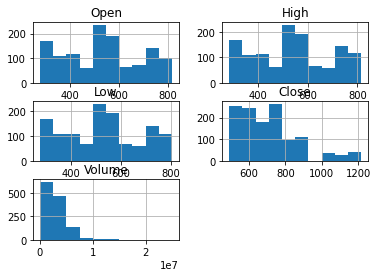

In [45]:
data.hist()

In [89]:
scaler = MinMaxScaler()
data_without_date = data[['Open','High','Low','Close','Volume']]
data_scaled = pd.DataFrame(scaler.fit_transform(data_without_date))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfcb8408d0>,
      dtype=object)

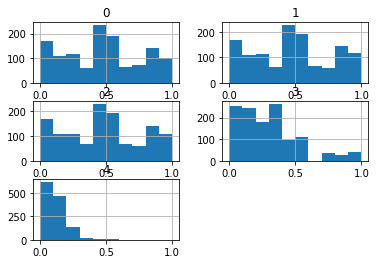

In [52]:
data_scaled.hist()

# Feature Engineering

**Drawing the Correlation Matrix**
Correlation Coefficient checking mechanism checks the relationship between the different features with the predicting attribute.

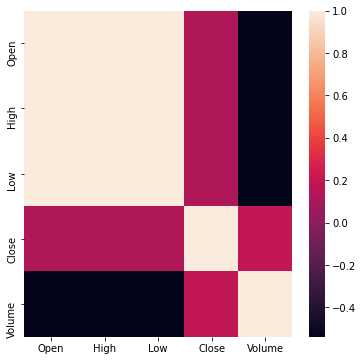

In [53]:
plt.figure(figsize=(6,6))
sns.heatmap(data.corr())

We can see from the correlation matrix that the features Open, High, and Low, all are highly correlated with each other. Therefore, it is sufficient to consider only one feature from the above 3 features and remove the rest.

Furthermore, I am removing the Close field since it contains many abnormal data values, which is like a contexual outlier.

In [90]:
data_scaled=data_scaled.drop([0,2,3], axis=1)
data_scaled

,1,4
0,0.096401,0.295258
1,0.098344,0.229936
2,0.092517,0.263612
3,0.088819,0.216179
4,0.076718,0.467797
...,...,...
1253,0.955292,0.024650
1254,0.964853,0.031286
1255,0.958074,0.045891
1256,0.942574,0.029491


# Developing the RNN Model

When developing an RNN Model, we have to reshape the data that we are feeding into the model. To do that, first we have to find a pattern in the data available and define the number of timesteps according to the pattern.

When considering the plots we have created for this we could not see a clear cut pattern/trend in the data by just visual inspection. Therefore, I have taken the following code snippet to split the data into a sequence by trying to identify any pattern available.

Since there are two features in our dataset after cleaning, I have used a split sequence method for a multivariate dataset.

In [59]:
def split_seq_multivariate(sequence, n_past, n_future):
    
    '''
    n_past ==> no of past observations
    n_future ==> no of future observations 
    '''
    x, y = [], [] 
    for window_start in range(len(sequence)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(sequence):
            break
        # slicing the past and future parts of the window
        past   = sequence[window_start:past_end, :]
        future = sequence[past_end:future_end, -1]
        x.append(past)
        y.append(future)
    
    return np.array(x), np.array(y)

In RNN, since we are dealing with time series data, we have to specify how many past data points we will be considering when generating the sequence.

In here, i have taken 60 past data points (time steps) when generating the data sequences.

In [91]:
# specify the window size
n_steps = 60

data_scaled = data_scaled.to_numpy()
data_scaled.shape


(1258, 2)

Next, I am using the split_seq_multivariate function to split the dataset into sequences.

In [92]:
# split into samples
X, y = split_seq_multivariate(data_scaled, n_steps,1)

In [94]:
# X is in the shape of [samples, timesteps, features]
print(X.shape)
print(y.shape)

# make y to the shape of [samples]
y=y[:,0]
y.shape


(1198, 60, 2)
(1198, 1)


(1198,)

**Splitting the Data**

In this step, I will be splitting the sequenced data into train and test sections with 0.2 test size.

Furthermore, i have split the training set again to train and validation data.
I have not used the test data to do the validation because validation data are used to fine tune the model, and if i used the testing data for validation purposes, then those data will be already seen by the model when trying to predict them later.

Ref: https://machinelearningmastery.com/difference-test-validation-datasets/

In [95]:
# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=50)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(958, 60, 2) (240, 60, 2) (958,) (240,)


In [101]:
# further dividing the training set into train and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=30)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(612, 60, 2) (154, 60, 2) (612,) (154,)


Next I am defining the model using Tensorflow Keras LSTM and Dense layers.

In the LSTM layer, i have not specified the activation function explicitly because  in the Keras Documentation it is specified that the default activation function for LSTM is tanh and default recurrent activation function is sigmoid. Therefore those default acivation functions will be used here.

Ref: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTMCell

**Define Model**

In [133]:
# define RNN model
model = Sequential()
model.add(LSTM(612, input_shape=(n_steps,2)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))

The following code line gives a summary of the model we have created, mentioning each layers information.

In [134]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 612)               1505520   
_________________________________________________________________
dense_32 (Dense)             (None, 50)                30650     
_________________________________________________________________
dense_33 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_34 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 31        
Total params: 1,540,281
Trainable params: 1,540,281
Non-trainable params: 0
_________________________________________________________________


**Compiling and Training the Model**

Next we will be compiling and fitting the model with the training data, and using the validation data to fine tune our model.

In [135]:
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [148]:
# fit the model
history = model.fit(X_train, y_train, epochs=250, batch_size=32, verbose=2, validation_data=(X_val, y_val))  # has used mini batch learning, with batch_size=32

Epoch 1/250
20/20 - 13s - loss: 0.0064 - mae: 0.0497 - val_loss: 0.0107 - val_mae: 0.0601
Epoch 2/250
20/20 - 13s - loss: 0.0124 - mae: 0.0736 - val_loss: 0.0119 - val_mae: 0.0843
Epoch 3/250
20/20 - 13s - loss: 0.0095 - mae: 0.0675 - val_loss: 0.0182 - val_mae: 0.0932
Epoch 4/250
20/20 - 13s - loss: 0.0094 - mae: 0.0648 - val_loss: 0.0095 - val_mae: 0.0630
Epoch 5/250
20/20 - 13s - loss: 0.0082 - mae: 0.0606 - val_loss: 0.0097 - val_mae: 0.0590
Epoch 6/250
20/20 - 13s - loss: 0.0083 - mae: 0.0592 - val_loss: 0.0091 - val_mae: 0.0596
Epoch 7/250
20/20 - 13s - loss: 0.0076 - mae: 0.0572 - val_loss: 0.0087 - val_mae: 0.0587
Epoch 8/250
20/20 - 13s - loss: 0.0080 - mae: 0.0575 - val_loss: 0.0084 - val_mae: 0.0566
Epoch 9/250
20/20 - 13s - loss: 0.0077 - mae: 0.0554 - val_loss: 0.0085 - val_mae: 0.0602
Epoch 10/250
20/20 - 13s - loss: 0.0068 - mae: 0.0523 - val_loss: 0.0073 - val_mae: 0.0460
Epoch 11/250
20/20 - 13s - loss: 0.0069 - mae: 0.0486 - val_loss: 0.0112 - val_mae: 0.0846
Epoch 12

We can visualize the training and validation RMSE of the model are as follows.

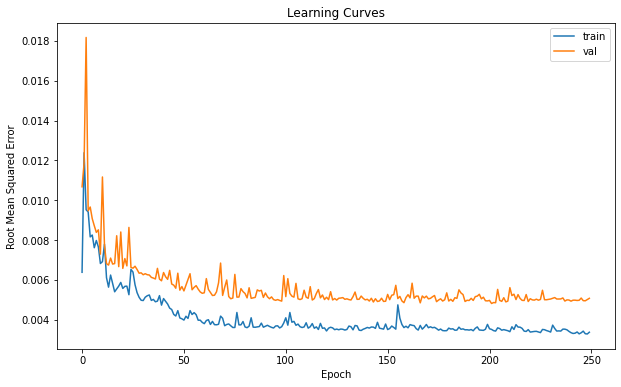

In [149]:
from matplotlib import pyplot
# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Root Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

**Model Evaluation and Predictions**

Next, i will be using the model.evaluate() and model.predict() methods. 

The model.evaluate() is used to only check the MSE, RMSE, MAE values of our model when the testing data is used. This does not provide us with the results the model would predict.
Therefore to see the results that the model would predict, i have used the model.predict() function. Later I have plotted the actual and predicted values of the test data to see how well our model has performed.

Ref: https://stackoverflow.com/questions/44476706/what-is-the-difference-between-keras-model-evaluate-and-model-predict

In [150]:
# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, np.sqrt(mse), mae)) 

MSE: 0.003, RMSE: 0.052, MAE: 0.031


In [151]:
# predicting y_test values
print(X_test.shape)
predicted_values = model.predict(X_test)
print(predicted_values.shape)
# print(predicted_values)

(240, 60, 2)
(240, 1)


<Figure size 720x432 with 0 Axes>

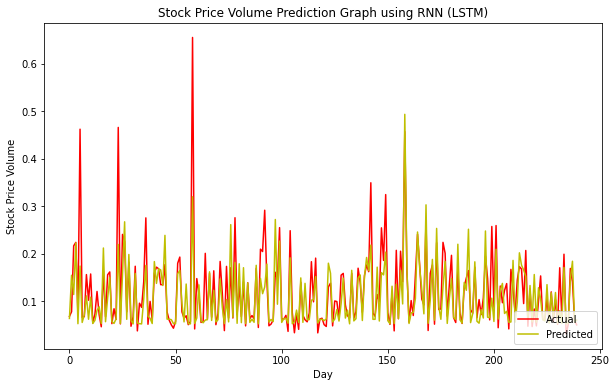

<Figure size 720x432 with 0 Axes>

In [152]:
plt.plot(y_test,c = 'r')
plt.plot(predicted_values,c = 'y')
plt.xlabel('Day')
plt.ylabel('Stock Price Volume')
plt.title('Stock Price Volume Prediction Graph using RNN (LSTM)')
plt.legend(['Actual','Predicted'],loc = 'lower right')
plt.figure(figsize=(10,6))

**Using R Squared**

The R squared is a metric we can use to evaluate how well our regression based (model that handle continuous data) have performed.

R squared can vary between 0 and 1 and we can evaluate our model using this metric, while a negative value would mean that the training has not been done properly.

In [153]:
# evaluating using R squared
R_square = r2_score(y_test, predicted_values) 
 
print(R_square)

0.5914172730027931
